In [128]:
import pandas as pd
import pydicom
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import cv2


# Load the CSV file with annotations
annotations_csv = r"E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\Data\1_Initial_Manual_Labeling.csv"  # Replace with the path to your CSV file
annotations_df = pd.read_csv(annotations_csv)


# Directory containing DICOM images from the CQ500 dataset
dicom_dir = r"E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\aria2-1.36.0-win-64bit-build1\aria2-1.36.0-win-64bit-build1\aria2-1.36"

# Create a dictionary to map SOP Instance UIDs to DICOM file paths
sop_uid_to_filepath = {}
for root, dirs, files in os.walk(dicom_dir):
    for file in files:
        if file.endswith(".dcm"):
            dicom_file_path = os.path.join(root, file)
            dicom_image = pydicom.dcmread(dicom_file_path)
            sop_uid = dicom_image.SOPInstanceUID
            sop_uid_to_filepath[sop_uid] = dicom_file_path

i = 0            
image_label_mapping = {}
image_array = []
label_array = []
for index, row in annotations_df.iterrows():
    sop_uid = row['SOPInstanceUID']
    #print(sop_uid)
    if sop_uid in sop_uid_to_filepath:
        dicom_image_path = sop_uid_to_filepath[sop_uid]
        dicom_image = pydicom.dcmread(dicom_image_path)
        ct_image = sitk.ReadImage(sop_uid_to_filepath[sop_uid])
        image_label_mapping[sop_uid] = (dicom_image, row)
        label_array.append(row)
        ct_array = sitk.GetArrayFromImage(ct_image)
        image_array.append(ct_array)
        i += 1
print(i, 'Done')

KeyboardInterrupt: 

In [ ]:
# Pre-processing  the image array
import numpy as np
import cv2

def pre_process_im_arr(image_array):
    # Define window levels and widths for brain tissue
    window_level = 40  # Adjust this value based on your data
    window_width = 80  # Adjust this value based on your data

    # Apply windowing to the CT scan
    min_value = window_level - window_width / 2
    max_value = window_level + window_width / 2
    image_array[image_array < min_value] = min_value
    image_array[image_array > max_value] = max_value

    # Normalize the HU values to the range [0, 255]
    image_array = ((image_array - min_value) / (max_value - min_value) * 255).astype(np.uint8)

    # Apply morphology dilation to remove noise
    kernel = np.ones((3, 3), np.uint8)  # Adjust the kernel size as needed
    dilated_image = cv2.dilate(image_array, kernel, iterations=1)

    # Squeeze the extra dimension to convert it into a 2D array
    dilated_image = dilated_image.squeeze()

    return dilated_image

for i in range (len(image_array)):
    image_array[i] = pre_process_im_arr(image_array[i])

In [ ]:
# Define the directory to save the PNG images
output_dir = r"E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\Outputs\output_png_images"

# Ensure the output directory exists, or create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through the pre-processed images in image_array and save them as PNG
for i, processed_image in enumerate(image_array):
    sop_uid = label_array[i]['SOPInstanceUID']

    # Resizing the image to 640x640
    processed_image = cv2.resize(processed_image, (640, 640))
    
    # Rename the output file as "image{i}.jpg"
    output_path = os.path.join(output_dir, f"image{i}.jpg")
    
    # Save the pre-processed image as a jpg
    cv2.imwrite(output_path, processed_image)

print(f"{i+1} pre-processed images saved as jpg in {output_dir}")



28 pre-processed images saved as jpg in E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\Outputs\output_png_images


In [ ]:
# Lists to store annotations and hemorrhage type labels
annotations = []
hemorrhage_labels = []

# Iterate through the 'labels' array, which contains both types of labels
for label_row in label_array:
    # Append the annotation data to the 'annotations' list
    annotations.append(label_row['data'])  # Replace 'Annotation_Column' with the actual column name for annotations
    # Append the hemorrhage type label to the 'hemorrhage_labels' list
    hemorrhage_labels.append(label_row['labelName'])  # Replace 'Hemorrhage_Type_Column' with the actual column name for hemorrhage types

In [ ]:
print(annotations[0])
print(hemorrhage_labels[0])

{'x': 263.13482999999997, 'y': 268.94382, 'width': 45.30338, 'height': 39.55057}
Intraparenchymal


In [ ]:
num_labels = []
for i in range(len(hemorrhage_labels)):
    if hemorrhage_labels[i] == 'Intraparenchymal':
        num_labels.append(0)
    elif hemorrhage_labels[i] == 'Intraventricular':
        num_labels.append(1)
    elif hemorrhage_labels[i] == 'Subarachnoid':
        num_labels.append(2)
    elif hemorrhage_labels[i] == 'Epidural':
        num_labels.append(3)
    elif hemorrhage_labels[i] == 'Subdural':
        num_labels.append(4)
    elif hemorrhage_labels[i] == 'No_Hemorrhage':
        num_labels.append(5)

In [ ]:
print(num_labels[0])
print(annotations[0])

0
{'x': 263.13482999999997, 'y': 268.94382, 'width': 45.30338, 'height': 39.55057}


In [ ]:
import json
import pandas as pd

# Your list of JSON strings
json_strings = annotations

# Initialize lists to store the parsed values
x_values = []
y_values = []
width_values = []
height_values = []

# Parse the JSON strings and extract values
for json_str in json_strings:
    data = json.loads(json_str.replace("'", "\""))  # Ensure single quotes are replaced with double quotes
    x_values.append(data['x'])
    y_values.append(data['y'])
    width_values.append(data['width'])
    height_values.append(data['height'])

# Create a DataFrame to store the values
df = pd.DataFrame({
    'x': x_values,
    'y': y_values,
    'width': width_values,
    'height': height_values
})

# Save the DataFrame to a CSV file
df.to_csv('annotations.csv', index=False)

In [ ]:
annotations_df = pd.read_csv('annotations.csv')

output_dir = r"E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\Outputs\output_labels"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, (_, row) in enumerate(annotations_df.iterrows()):
    x = row['x']
    y = row['y']
    width = row['width']
    height = row['height']

    label_new = [num_labels[i], (x+width/2)/512, (y+height/2)/512, width/512, height/512]
    label_string = ' '.join(map(str, label_new))  # Convert elements to strings and join with spaces

    # Define the unique file name for each label_string (e.g., using index i)
    output_file = os.path.join(output_dir, f"image{i}.txt")

    with open(output_file, 'w') as file:
        file.write(label_string)

print(f"Values saved to {output_dir}")


Values saved to E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\Outputs\output_labels


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the directory where your pre-processed images (PNG) are located
image_dir =  r"E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\Outputs\output_png_images"

# Define the directory where your label text files are located
label_dir = r"E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\Outputs\output_labels"

# Define the directories for saving training and validation images
train_image_dir = r"E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\Outputs\train_data\images\train"
val_image_dir = r"E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\Outputs\train_data\images\val"

# Define the directories for saving training and validation labels
train_label_dir = r"E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\Outputs\train_data\labels\train"
val_label_dir = r"E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\Outputs\train_data\labels\val"

# List all the image files and label files
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
label_files = [f for f in os.listdir(label_dir) if f.endswith(".txt")]

# Ensure that the lists are sorted for consistency
image_files.sort()
label_files.sort()

# Split the dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    image_files, label_files, test_size=0.2, random_state=42
)

# Print the number of training and validation images
print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")

# Copy training images to the training directory
for image in train_images:
    source_path = os.path.join(image_dir, image)
    destination_path = os.path.join(train_image_dir, image)
    shutil.copy(source_path, destination_path)

# Copy validation images to the validation directory
for image in val_images:
    source_path = os.path.join(image_dir, image)
    destination_path = os.path.join(val_image_dir, image)
    shutil.copy(source_path, destination_path)

# Copy training labels to the training directory
for label in train_labels:
    source_path = os.path.join(label_dir, label)
    destination_path = os.path.join(train_label_dir, label)
    shutil.copy(source_path, destination_path)

# Copy validation labels to the validation directory
for label in val_labels:
    source_path = os.path.join(label_dir, label)
    destination_path = os.path.join(val_label_dir, label)
    shutil.copy(source_path, destination_path)


Number of training images: 22
Number of validation images: 6


Image 0


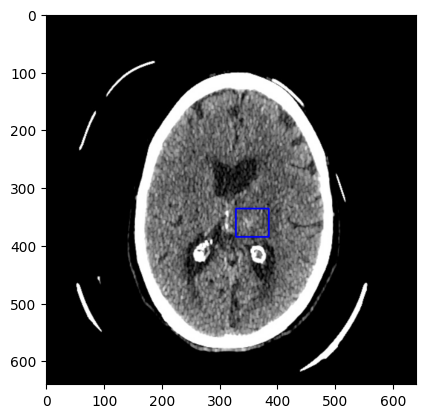

(640, 640, 3)
Image 1


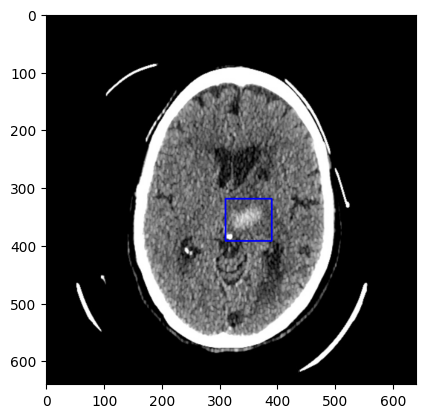

(640, 640, 3)
Image 2


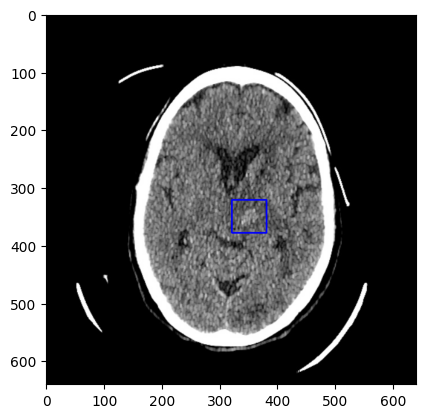

(640, 640, 3)
Image 3


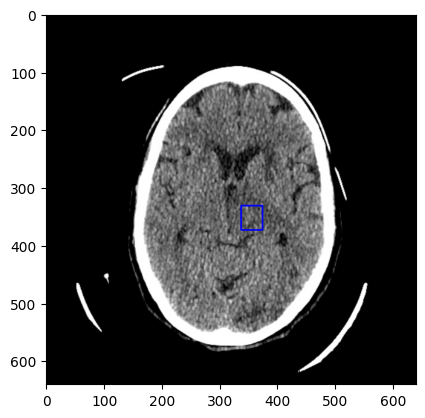

(640, 640, 3)
Image 4


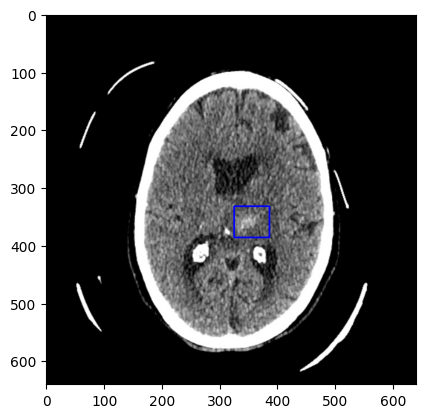

(640, 640, 3)
Image 5


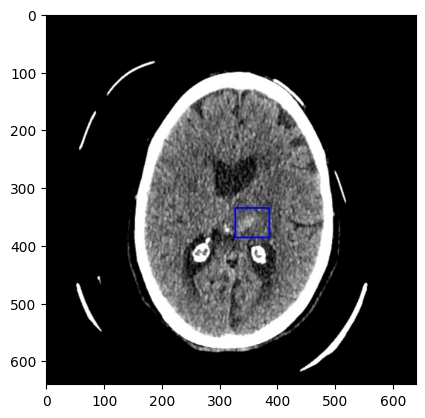

(640, 640, 3)
Image 6


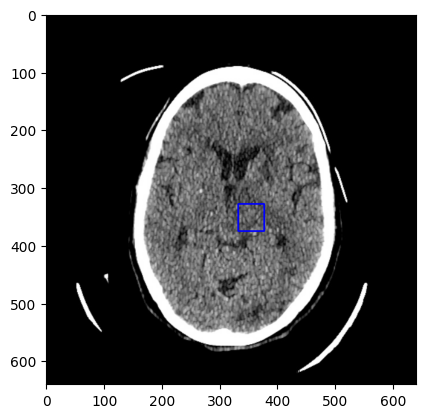

(640, 640, 3)
Image 7


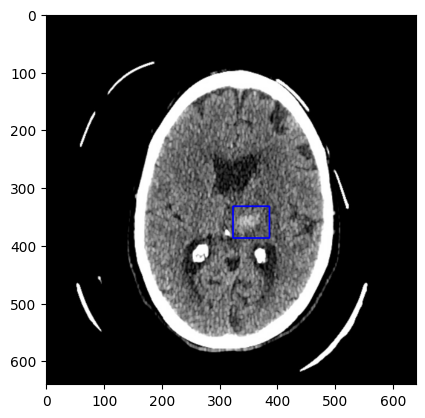

(640, 640, 3)
Image 8


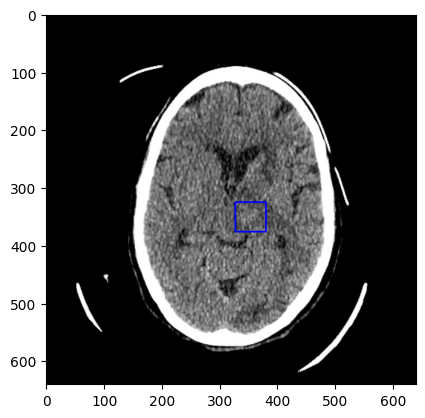

(640, 640, 3)
Image 9


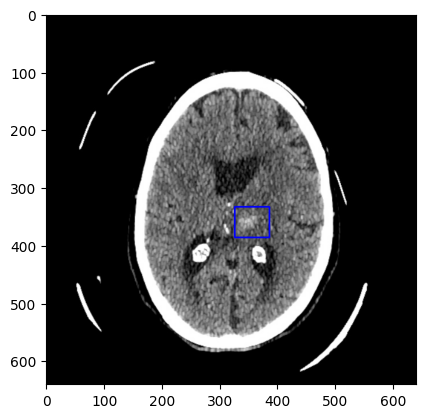

(640, 640, 3)
Image 10


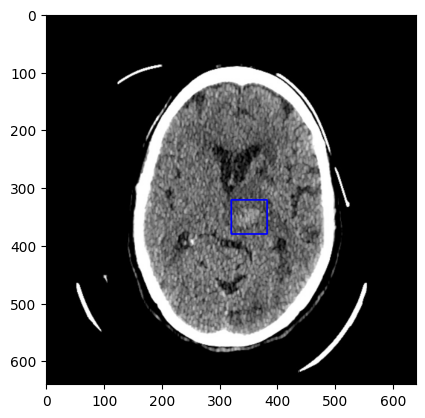

(640, 640, 3)
Image 11


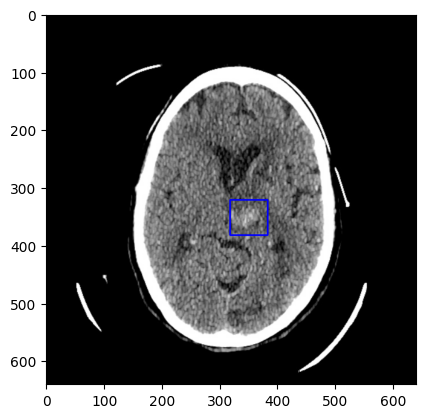

(640, 640, 3)
Image 12


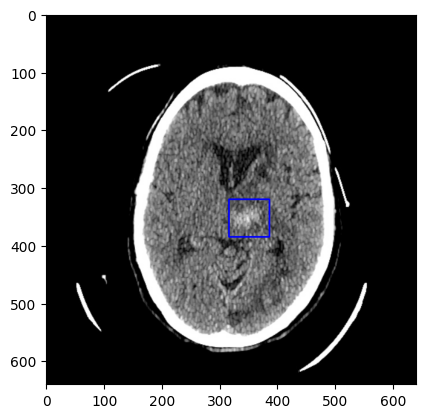

(640, 640, 3)
Image 13


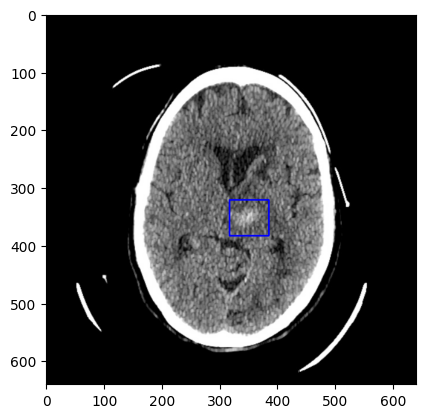

(640, 640, 3)
Image 14


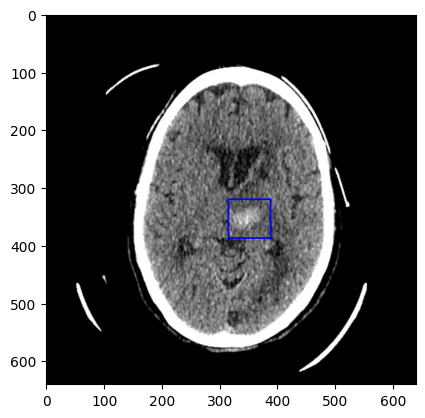

(640, 640, 3)
Image 15


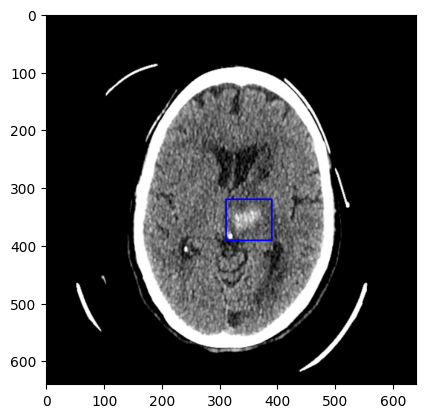

(640, 640, 3)
Image 16


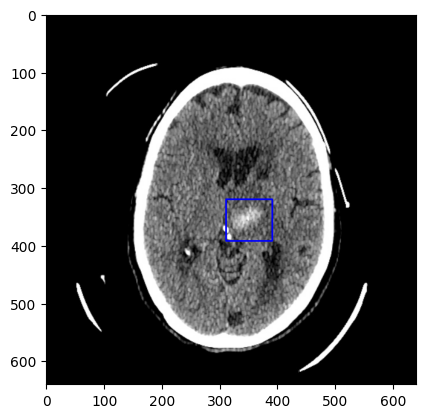

(640, 640, 3)
Image 17


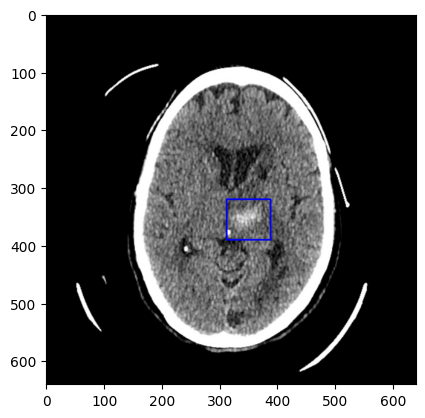

(640, 640, 3)
Image 18


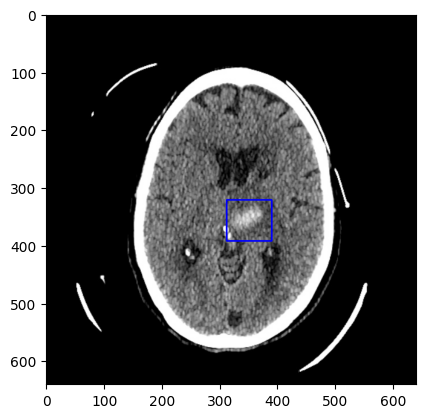

(640, 640, 3)
Image 19


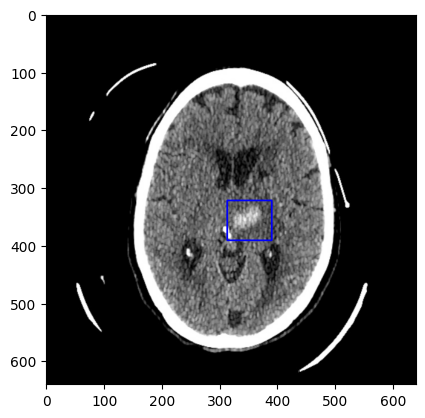

(640, 640, 3)
Image 20


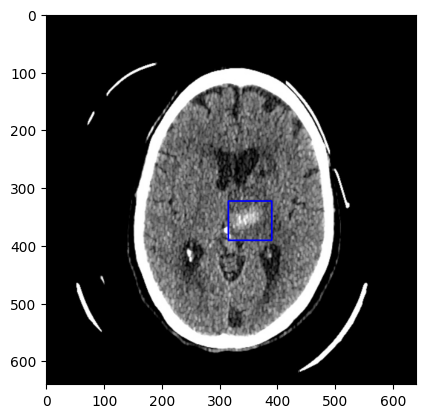

(640, 640, 3)
Image 21


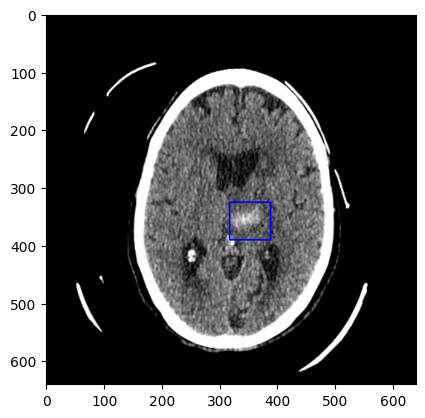

(640, 640, 3)
Image 22


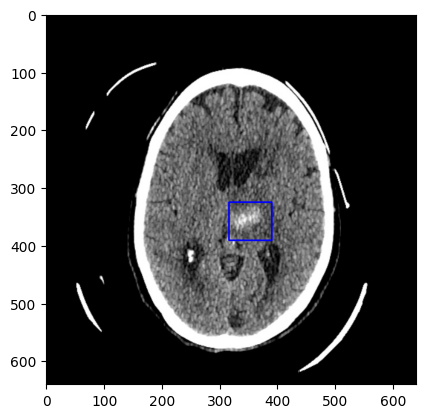

(640, 640, 3)
Image 23


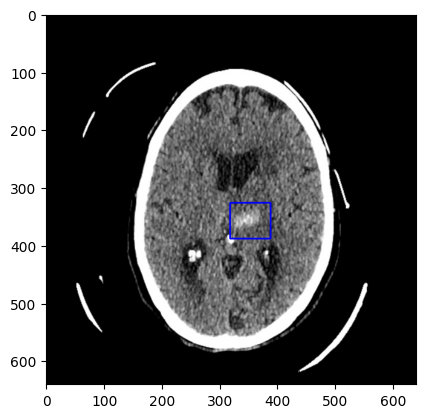

(640, 640, 3)
Image 24


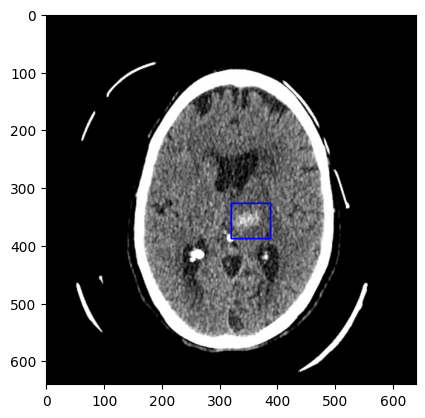

(640, 640, 3)
Image 25


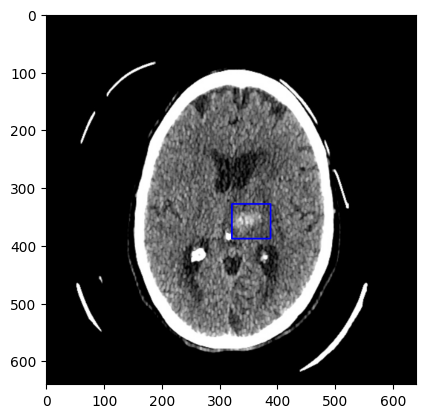

(640, 640, 3)
Image 26


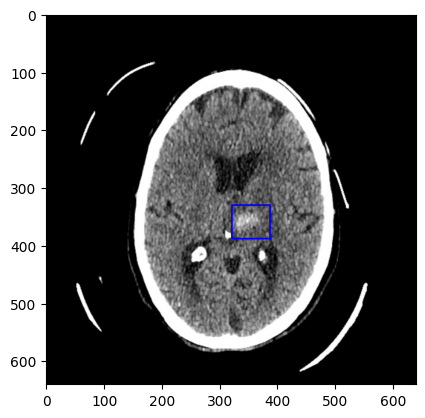

(640, 640, 3)
Image 27


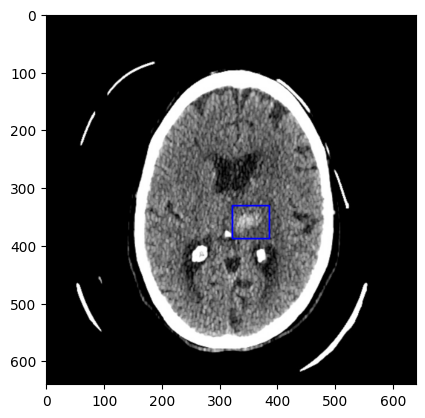

(640, 640, 3)


In [ ]:
'''# Plot images with bounding boxes
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the directory containing the images
image_dir = r"E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\Outputs\output_png_images"

# Define the directory containing the labels
label_dir = r"E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\Outputs\output_labels"

# Plot the first 10 images
for i in range(28):
    # Read the image
    image_path = os.path.join(image_dir, f"image{i}.jpg")
    image = cv2.imread(image_path)

    # Read the label
    label_path = os.path.join(label_dir, f"image{i}.txt")
    with open(label_path, 'r') as file:
        label = file.read()

    # Parse the label string
    label = label.split()
    label = [float(x) for x in label]

    # Extract the label values
    class_id = int(label[0])
    x = label[1] * 640
    y = label[2] * 640
    width = label[3] * 640
    height = label[4] * 640

    # Calculate the top-left corner coordinates
    left = x - width / 2
    top = y - height / 2

    # Draw the bounding box
    cv2.rectangle(image, (int(left), int(top)), (int(left + width), int(top + height)), (255, 0, 0), 2)

    # Convert the image from BGR (OpenCV format) to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    print(f"Image {i}")
    plt.imshow(image)
    plt.show()
    print(image.shape)
'''